In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.interpolate import interp1d
from tqdm import tqdm
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore')

In [ ]:
import os
os.mkdir('Ground_Water_Level_Stations')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/AIS_2022_03_31.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
import zipfile
with zipfile.ZipFile('/content/Ground_Water_Level_Stations.zip', 'r') as zip_ref:
    zip_ref.extractall('./Ground_Water_Level_Stations')

In [ ]:
df = pd.read_csv('/content/AIS_2022_03_31.csv')
df.head()

MMSI         BaseDateTime       LAT        LON  SOG    COG  Heading  \
0  367702220  2022-03-31T00:00:01  29.78763  -95.08070  0.1  226.5    340.0   
1  671226100  2022-03-31T00:00:01  25.77626  -80.20320  3.2  143.7    511.0   
2  367767250  2022-03-31T00:00:01  29.31623  -94.78829  4.5  228.1    511.0   
3  338327436  2022-03-31T00:00:03  47.29634 -122.42233  0.0  360.0    511.0   
4  367452810  2022-03-31T00:00:06  29.32824  -94.77391  2.6  319.2    511.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0      JOE B WARD         NaN  WDI4808        31.0    12.0    21.0    8.0   
1     RELIANCE II  IMO9221322    5VHS7        79.0     0.0    52.0   12.0   
2          GLEN K         NaN  WDJ3358        52.0     0.0     0.0    0.0   
3        COOL KAT  IMO0000000      NaN        36.0     NaN    15.0    3.0   
4  JOHN W JOHNSON  IMO9602344  WDF4516        60.0     0.0    80.0   19.0   

   Draft  Cargo TransceiverClass  
0    NaN   57.0                A  
1    2.5   70.0                A  
2    0.0   52.0                A  
3    NaN    NaN                B  
4    3.0   60.0                A

In [ ]:
df.shape

(7167046, 17)

In [ ]:
df.isna().sum()

MMSI                      0
BaseDateTime              0
LAT                       0
LON                       0
SOG                       0
COG                       0
Heading                   0
VesselName            17201
IMO                 3368784
CallSign             833343
VesselType              817
Status              1628738
Length               438196
Width               1174077
Draft               4461321
Cargo               1624947
TransceiverClass          0
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df = df[['BaseDateTime','MMSI','IMO','LAT','LON','SOG','COG']]

In [ ]:
df.isna().sum()

BaseDateTime    0
MMSI            0
IMO             0
LAT             0
LON             0
SOG             0
COG             0
dtype: int64

In [ ]:
df.shape

(1979165, 7)

In [ ]:
df.to_csv('./modified_ais_data.csv',index=False)

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point as ShapelyPoint
from tqdm import tqdm
from math import atan2, radians, degrees, sin, cos

def sliding_window_segmentation(data, window_size, step_size, mmsi):
    """
    Perform sliding window segmentation on the given DataFrame.

    Parameters:
    - data: Pandas DataFrame containing the trajectory.
    - window_size: The number of data points in each sliding window.
    - step_size: The step size for the sliding window.
    - mmsi: MMSI of the vessel for this segment.

    Returns:
    - segments: A list of DataFrames, each representing a segmented window.
    """
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size].copy()
        window['MMSI'] = mmsi  # Explicitly set MMSI for each segment
        segments.append(window)
    return segments

def lat_lon_range(df_file):
    """
    Calculate the bounding box for latitude and longitude.

    Parameters:
    - df_file: DataFrame containing 'LAT' and 'LON' columns.

    Returns:
    - min_lat, max_lat, min_lon, max_lon: Integer values defining the bounding box.
    """
    min_lat, max_lat = df_file['LAT'].min(), df_file['LAT'].max()
    min_lon, max_lon = df_file['LON'].min(), df_file['LON'].max()
    min_lat, max_lat, min_lon, max_lon = (
        int(np.floor(min_lat)),
        int(np.ceil(max_lat)),
        int(np.floor(min_lon)),
        int(np.ceil(max_lon)),
    )
    return min_lat, max_lat, min_lon, max_lon

def calculate_initial_bearing(start_lat, start_lon, end_lat, end_lon):
    """
    Calculate the initial bearing (forward azimuth) between two geodesic points.

    Parameters:
    - start_lat, start_lon: Coordinates of the starting point.
    - end_lat, end_lon: Coordinates of the ending point.

    Returns:
    - bearing: Initial bearing in degrees.
    """
    start_lat, start_lon, end_lat, end_lon = map(radians, [start_lat, start_lon, end_lat, end_lon])
    delta_lon = end_lon - start_lon
    x = sin(delta_lon) * cos(end_lat)
    y = cos(start_lat) * sin(end_lat) - sin(start_lat) * cos(end_lat) * cos(delta_lon)
    bearing = atan2(x, y)
    return (degrees(bearing) + 360) % 360  # Normalize to 0-360 degrees

def geodesic_interpolation(start_lat, start_lon, end_lat, end_lon, num_points, water_mask):
    """
    Perform geodesic interpolation between two points while ensuring points remain on water.

    Parameters:
    - start_lat, start_lon: Coordinates of the start point.
    - end_lat, end_lon: Coordinates of the end point.
    - num_points: Number of intermediate points to generate.
    - water_mask: GeoDataFrame containing water polygons.

    Returns:
    - lats, lons: Lists of interpolated latitude and longitude values.
    """
    start_point = ShapelyPoint(start_lon, start_lat)
    total_distance = geodesic((start_lat, start_lon), (end_lat, end_lon)).meters
    bearing = calculate_initial_bearing(start_lat, start_lon, end_lat, end_lon)

    lats, lons = [], []
    spatial_index = water_mask.sindex  # Create a spatial index for efficient lookups
    buffered_water_mask = water_mask.buffer(0.01)  # Apply a small buffer (~1 km)

    for frac in np.linspace(0, 1, num_points):
        distance_to_point = total_distance * frac
        interpolated_point = geodesic(meters=distance_to_point).destination((start_lat, start_lon), bearing)
        lat, lon = interpolated_point.latitude, interpolated_point.longitude

        point = ShapelyPoint(lon, lat)

        # Filter water polygons using spatial index
        possible_matches_index = list(spatial_index.intersection(point.bounds))
        possible_matches = buffered_water_mask.iloc[possible_matches_index]

        if not possible_matches.contains(point).any():
            print(f"Skipping interpolated point on land or near boundary: ({lat}, {lon})")
            continue

        lats.append(lat)
        lons.append(lon)

    return lats, lons

def prepare_ais_data_with_geodesic_interpolation(
    data, bounding_box, window_size, step_size, water_mask, min_resample_interval=900  # 15 minutes in seconds
):
    """
    Prepare AIS data using geodesic interpolation and sliding window segmentation.

    Parameters:
    - data: Pandas DataFrame containing AIS data.
    - bounding_box: Tuple defining the bounding box (min_lat, max_lat, min_lon, max_lon).
    - window_size: The number of data points in each sliding window.
    - step_size: The step size for the sliding window.
    - water_mask: GeoDataFrame containing water polygons.
    - min_resample_interval: Minimum resampling interval in seconds.

    Returns:
    - combined_df: A single DataFrame containing all segmented trajectories.
    """
    min_lat, max_lat, min_lon, max_lon = bounding_box

    # Step 1: Apply bounding box filter
    filtered_data = data[
        (data['LAT'] >= min_lat) & (data['LAT'] <= max_lat) &
        (data['LON'] >= min_lon) & (data['LON'] <= max_lon)
    ]

    # Step 2: Aggregate by MMSI and sort by timestamp
    grouped = filtered_data.groupby('MMSI')
    segments = []
    segment_id = 0

    # Step 3: Process each MMSI group
    for mmsi, group in tqdm(grouped, desc="Processing MMSI", unit="MMSI"):
        group = group.sort_values(by='BaseDateTime')
        group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])

        # Step 4: Interpolate data using geodesic interpolation
        resampled_traj = []

        for i in range(len(group) - 1):
            start_row = group.iloc[i]
            end_row = group.iloc[i + 1]

            # Calculate time difference
            time_diff = (end_row['BaseDateTime'] - start_row['BaseDateTime']).total_seconds()

            if time_diff < min_resample_interval:
                print(f"Skipping interpolation for gap < 15 minutes between {start_row['BaseDateTime']} and {end_row['BaseDateTime']}")
                resampled_traj.append((start_row['BaseDateTime'], start_row['LAT'], start_row['LON'], start_row['SOG'], start_row['COG']))
                continue

            num_points = int(time_diff / min_resample_interval) + 1
            print(f"Performing interpolation for gap >= 15 minutes between {start_row['BaseDateTime']} and {end_row['BaseDateTime']} with {num_points} points")

            # Perform geodesic interpolation
            lats, lons = geodesic_interpolation(
                start_row['LAT'], start_row['LON'],
                end_row['LAT'], end_row['LON'],
                num_points, water_mask
            )

            # Interpolate SOG and COG linearly
            sog_interp = np.linspace(start_row['SOG'], end_row['SOG'], len(lats))
            cog_interp = np.linspace(start_row['COG'], end_row['COG'], len(lats))

            # Generate timestamps
            timestamps = pd.date_range(
                start=start_row['BaseDateTime'],
                end=end_row['BaseDateTime'],
                periods=len(lats)
            )

            # Append interpolated points to trajectory
            resampled_traj.extend(zip(timestamps, lats, lons, sog_interp, cog_interp))

        # Ensure the last point is included
        resampled_traj.append((end_row['BaseDateTime'], end_row['LAT'], end_row['LON'], end_row['SOG'], end_row['COG']))

        resampled_df = pd.DataFrame(resampled_traj, columns=['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG'])

        # Perform sliding window segmentation
        trajectory_segments = sliding_window_segmentation(resampled_df, window_size, step_size, mmsi)

        for segment in trajectory_segments:
            segment['SegmentID'] = segment_id
            segments.append(segment)
            segment_id += 1

    # Combine all segmented trajectories into a single DataFrame
    combined_df = pd.concat(segments, ignore_index=True)
    return combined_df

# Example usage
if __name__ == "__main__":
    # Load AIS data
    df = pd.read_csv("/path/to/modified_ais_data.csv")
    df = df[:10000]

    # Load water mask (shapefile with global water boundaries)
    water_mask = gpd.read_file("/path/to/world_shapefile.shp")

    # Calculate bounding box
    min_lat, max_lat, min_lon, max_lon = lat_lon_range(df)
    bounding_box = (min_lat, max_lat, min_lon, max_lon)

    # Define window size and step size
    window_size = 10
    step_size = 5

    # Process AIS data
    segmented_trajectories_df = prepare_ais_data_with_geodesic_interpolation(
        df, bounding_box, window_size, step_size, water_mask, min_resample_interval=900  # 15 minutes
    )

    # Save segmented trajectories to CSV
    segmented_trajectories_df.to_csv("segmented_trajectories.csv", index=False)


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point as ShapelyPoint
from tqdm import tqdm
from math import atan2, radians, degrees, sin, cos

def sliding_window_segmentation(data, window_size, step_size, mmsi):
    """
    Perform sliding window segmentation on the given DataFrame.

    Parameters:
    - data: Pandas DataFrame containing the trajectory.
    - window_size: The number of data points in each sliding window.
    - step_size: The step size for the sliding window.
    - mmsi: MMSI of the vessel for this segment.

    Returns:
    - segments: A list of DataFrames, each representing a segmented window.
    """
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size].copy()
        window['MMSI'] = mmsi  # Explicitly set MMSI for each segment
        segments.append(window)
    return segments

def lat_lon_range(df_file):
    """
    Calculate the bounding box for latitude and longitude.

    Parameters:
    - df_file: DataFrame containing 'LAT' and 'LON' columns.

    Returns:
    - min_lat, max_lat, min_lon, max_lon: Integer values defining the bounding box.
    """
    min_lat, max_lat = df_file['LAT'].min(), df_file['LAT'].max()
    min_lon, max_lon = df_file['LON'].min(), df_file['LON'].max()
    min_lat, max_lat, min_lon, max_lon = (
        int(np.floor(min_lat)),
        int(np.ceil(max_lat)),
        int(np.floor(min_lon)),
        int(np.ceil(max_lon)),
    )
    return min_lat, max_lat, min_lon, max_lon

def calculate_initial_bearing(start_lat, start_lon, end_lat, end_lon):
    """
    Calculate the initial bearing (forward azimuth) between two geodesic points.

    Parameters:
    - start_lat, start_lon: Coordinates of the starting point.
    - end_lat, end_lon: Coordinates of the ending point.

    Returns:
    - bearing: Initial bearing in degrees.
    """
    start_lat, start_lon, end_lat, end_lon = map(radians, [start_lat, start_lon, end_lat, end_lon])
    delta_lon = end_lon - start_lon
    x = sin(delta_lon) * cos(end_lat)
    y = cos(start_lat) * sin(end_lat) - sin(start_lat) * cos(end_lat) * cos(delta_lon)
    bearing = atan2(x, y)
    return (degrees(bearing) + 360) % 360  # Normalize to 0-360 degrees

def geodesic_interpolation(start_lat, start_lon, end_lat, end_lon, num_points, water_mask):
    """
    Perform geodesic interpolation between two points while ensuring points remain on water.

    Parameters:
    - start_lat, start_lon: Coordinates of the start point.
    - end_lat, end_lon: Coordinates of the end point.
    - num_points: Number of intermediate points to generate.
    - water_mask: GeoDataFrame containing water polygons.

    Returns:
    - lats, lons: Lists of interpolated latitude and longitude values.
    """
    start_point = ShapelyPoint(start_lon, start_lat)
    total_distance = geodesic((start_lat, start_lon), (end_lat, end_lon)).meters
    bearing = calculate_initial_bearing(start_lat, start_lon, end_lat, end_lon)

    lats, lons = [], []
    spatial_index = water_mask.sindex  # Create a spatial index for efficient lookups
    buffered_water_mask = water_mask.buffer(0.01)  # Apply a small buffer (~1 km)

    for frac in np.linspace(0, 1, num_points):
        distance_to_point = total_distance * frac
        interpolated_point = geodesic(meters=distance_to_point).destination((start_lat, start_lon), bearing)
        lat, lon = interpolated_point.latitude, interpolated_point.longitude

        point = ShapelyPoint(lon, lat)

        # Filter water polygons using spatial index
        possible_matches_index = list(spatial_index.intersection(point.bounds))
        possible_matches = buffered_water_mask.iloc[possible_matches_index]

        if not possible_matches.contains(point).any():
            print(f"Skipping interpolated point on land or near boundary: ({lat}, {lon})")
            continue

        lats.append(lat)
        lons.append(lon)

    return lats, lons

def prepare_ais_data_with_geodesic_interpolation(
    data, bounding_box, window_size, step_size, water_mask, min_resample_interval=900  # 15 minutes in seconds
):
    """
    Prepare AIS data using geodesic interpolation and sliding window segmentation.

    Parameters:
    - data: Pandas DataFrame containing AIS data.
    - bounding_box: Tuple defining the bounding box (min_lat, max_lat, min_lon, max_lon).
    - window_size: The number of data points in each sliding window.
    - step_size: The step size for the sliding window.
    - water_mask: GeoDataFrame containing water polygons.
    - min_resample_interval: Minimum resampling interval in seconds.

    Returns:
    - combined_df: A single DataFrame containing all segmented trajectories.
    """
    min_lat, max_lat, min_lon, max_lon = bounding_box

    # Step 1: Apply bounding box filter
    filtered_data = data[
        (data['LAT'] >= min_lat) & (data['LAT'] <= max_lat) &
        (data['LON'] >= min_lon) & (data['LON'] <= max_lon)
    ]

    # Step 2: Aggregate by MMSI and sort by timestamp
    grouped = filtered_data.groupby('MMSI')
    segments = []
    segment_id = 0

    # Step 3: Process each MMSI group
    for mmsi, group in tqdm(grouped, desc="Processing MMSI", unit="MMSI"):
        group = group.sort_values(by='BaseDateTime')
        group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])

        # Step 4: Interpolate data using geodesic interpolation
        resampled_traj = []

        for i in range(len(group) - 1):
            start_row = group.iloc[i]
            end_row = group.iloc[i + 1]

            # Calculate time difference
            time_diff = (end_row['BaseDateTime'] - start_row['BaseDateTime']).total_seconds()

            if time_diff < min_resample_interval:
                print(f"Skipping interpolation for gap < 15 minutes between {start_row['BaseDateTime']} and {end_row['BaseDateTime']}")
                resampled_traj.append((start_row['BaseDateTime'], start_row['LAT'], start_row['LON'], start_row['SOG'], start_row['COG']))
                continue

            num_points = int(time_diff / min_resample_interval) + 1
            print(f"Performing interpolation for gap >= 15 minutes between {start_row['BaseDateTime']} and {end_row['BaseDateTime']} with {num_points} points")

            # Perform geodesic interpolation
            lats, lons = geodesic_interpolation(
                start_row['LAT'], start_row['LON'],
                end_row['LAT'], end_row['LON'],
                num_points, water_mask
            )

            # Interpolate SOG and COG linearly
            sog_interp = np.linspace(start_row['SOG'], end_row['SOG'], len(lats))
            cog_interp = np.linspace(start_row['COG'], end_row['COG'], len(lats))

            # Generate timestamps
            timestamps = pd.date_range(
                start=start_row['BaseDateTime'],
                end=end_row['BaseDateTime'],
                periods=len(lats)
            )

            # Append interpolated points to trajectory
            resampled_traj.extend(zip(timestamps, lats, lons, sog_interp, cog_interp))

        # Ensure the last point is included
        resampled_traj.append((end_row['BaseDateTime'], end_row['LAT'], end_row['LON'], end_row['SOG'], end_row['COG']))

        resampled_df = pd.DataFrame(resampled_traj, columns=['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG'])

        # Perform sliding window segmentation
        trajectory_segments = sliding_window_segmentation(resampled_df, window_size, step_size, mmsi)

        for segment in trajectory_segments:
            segment['SegmentID'] = segment_id
            segments.append(segment)
            segment_id += 1

    # Combine all segmented trajectories into a single DataFrame
    combined_df = pd.concat(segments, ignore_index=True)
    return combined_df

# Example usage
if __name__ == "__main__":
    # Load AIS data
    df = pd.read_csv("/path/to/modified_ais_data.csv")
    df = df[:10000]

    # Load water mask (shapefile with global water boundaries)
    water_mask = gpd.read_file("/path/to/world_shapefile.shp")

    # Calculate bounding box
    min_lat, max_lat, min_lon, max_lon = lat_lon_range(df)
    bounding_box = (min_lat, max_lat, min_lon, max_lon)

    # Define window size and step size
    window_size = 10
    step_size = 5

    # Process AIS data
    segmented_trajectories_df = prepare_ais_data_with_geodesic_interpolation(
        df, bounding_box, window_size, step_size, water_mask, min_resample_interval=900  # 15 minutes
    )



######################################################################################################

In [26]:
!pip install geopandas ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.interpolate import interp1d
from tqdm import tqdm
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore')

In [ ]:
!pip3 install geopandas
!pip3 install shapely

In [28]:
import geopandas as gpd
import seaborn as sns
# from shapely.gemetry import Point as ShapelyPoint
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

In [29]:
df = pd.read_csv('./modified_ais_data.csv')

In [30]:
df.head()

BaseDateTime       MMSI         IMO       LAT        LON   SOG  \
0  2022-03-31T00:00:01  671226100  IMO9221322  25.77626  -80.20320   3.2   
1  2022-03-31T00:00:06  367452810  IMO9602344  29.32824  -94.77391   2.6   
2  2022-03-31T00:00:09  366919770  IMO9253583  48.74428 -122.49504   0.0   
3  2022-03-31T00:00:00  311000966  IMO8916607  18.55833  -66.47910  17.5   
4  2022-03-31T00:00:01  219028420  IMO9411305  28.66703  -93.59339   9.5   

     COG  
0  143.7  
1  319.2  
2  210.3  
3  274.5  
4  129.4

<Axes: xlabel='LON', ylabel='LAT'>

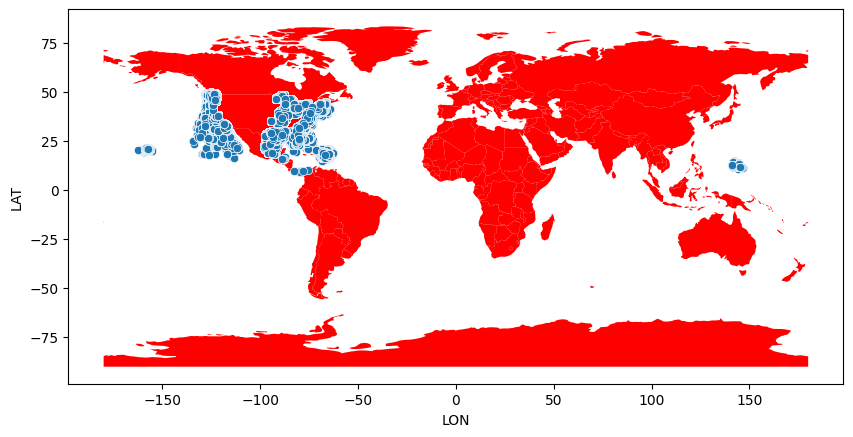

In [31]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
ax1 = world.plot(marker='o',color='red',markersize=5,
                 figsize=(10,10))
sns.scatterplot(data=df, x='LON', y='LAT', ax=ax1)


In [43]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geopy.distance import geodesic
from shapely.geometry import Point as ShapelyPoint
from tqdm import tqdm
from math import atan2, radians, degrees, sin, cos

def sliding_window_segmentation(data, window_size, step_size, mmsi):
    segments = []
    for start in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[start:start + window_size].copy()
        window['MMSI'] = mmsi
        segments.append(window)
    return segments

def lat_lon_range(df_file):
    min_lat, max_lat = df_file['LAT'].min(), df_file['LAT'].max()
    min_lon, max_lon = df_file['LON'].min(), df_file['LON'].max()
    min_lat, max_lat, min_lon, max_lon = (
        int(np.floor(min_lat)),
        int(np.ceil(max_lat)),
        int(np.floor(min_lon)),
        int(np.ceil(max_lon)),
    )
    return min_lat, max_lat, min_lon, max_lon

def calculate_initial_bearing(start_lat, start_lon, end_lat, end_lon):
    start_lat, start_lon, end_lat, end_lon = map(radians, [start_lat, start_lon, end_lat, end_lon])
    delta_lon = end_lon - start_lon
    x = sin(delta_lon) * cos(end_lat)
    y = cos(start_lat) * sin(end_lat) - sin(start_lat) * cos(end_lat) * cos(delta_lon)
    bearing = atan2(x, y)
    return (degrees(bearing) + 360) % 360

def geodesic_interpolation(start_lat, start_lon, end_lat, end_lon, num_points, start_time, end_time, water_mask):
    start_point = ShapelyPoint(start_lon, start_lat)
    total_distance = geodesic((start_lat, start_lon), (end_lat, end_lon)).meters
    bearing = calculate_initial_bearing(start_lat, start_lon, end_lat, end_lon)

    lats, lons, times = [], [], []
    spatial_index = water_mask.sindex
    buffered_water_mask = water_mask.buffer(0.01)

    timestamps = pd.date_range(start=start_time, end=end_time, periods=num_points)

    for frac, timestamp in zip(np.linspace(0, 1, num_points), timestamps):
        distance_to_point = total_distance * frac
        interpolated_point = geodesic(meters=distance_to_point).destination((start_lat, start_lon), bearing)
        lat, lon = interpolated_point.latitude, interpolated_point.longitude

        point = ShapelyPoint(lon, lat)
        possible_matches_index = list(spatial_index.intersection(point.bounds))
        possible_matches = buffered_water_mask.iloc[possible_matches_index]

        if not possible_matches.contains(point).any():
            print(f"Skipping interpolated point on land or near boundary: ({lat}, {lon})")
            continue

        lats.append(lat)
        lons.append(lon)
        times.append(timestamp)

    return lats, lons, times

def prepare_ais_data_with_geodesic_interpolation(
    data, bounding_box, window_size, step_size, water_mask, min_resample_interval=90
):
    min_lat, max_lat, min_lon, max_lon = bounding_box

    filtered_data = data[
        (data['LAT'] >= min_lat) & (data['LAT'] <= max_lat) &
        (data['LON'] >= min_lon) & (data['LON'] <= max_lon)
    ]

    grouped = filtered_data.groupby('MMSI')
    segments = []
    segment_id = 0

    for mmsi, group in tqdm(grouped, desc="Processing MMSI", unit="MMSI"):
        group = group.sort_values(by='BaseDateTime')
        group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])

        resampled_traj = []

        for i in range(len(group) - 1):
            start_row = group.iloc[i]
            end_row = group.iloc[i + 1]

            time_diff = (end_row['BaseDateTime'] - start_row['BaseDateTime']).total_seconds()

            if time_diff < min_resample_interval:
                print(f"Skipping interpolation for gap < 15 minutes between {start_row['BaseDateTime']} and {end_row['BaseDateTime']}")
                resampled_traj.append((start_row['BaseDateTime'], start_row['LAT'], start_row['LON'], start_row['SOG'], start_row['COG']))
                continue

            num_points = int(time_diff / min_resample_interval) + 1
            print(f"Performing interpolation for gap >= 15 minutes between {start_row['BaseDateTime']} and {end_row['BaseDateTime']} with {num_points} points")

            lats, lons, times = geodesic_interpolation(
                start_row['LAT'], start_row['LON'],
                end_row['LAT'], end_row['LON'],
                num_points, start_row['BaseDateTime'], end_row['BaseDateTime'], water_mask
            )

            sog_interp = np.linspace(start_row['SOG'], end_row['SOG'], len(lats))
            cog_interp = np.linspace(start_row['COG'], end_row['COG'], len(lats))

            resampled_traj.extend(zip(times, lats, lons, sog_interp, cog_interp))

        resampled_traj.append((end_row['BaseDateTime'], end_row['LAT'], end_row['LON'], end_row['SOG'], end_row['COG']))
        resampled_df = pd.DataFrame(resampled_traj, columns=['BaseDateTime', 'LAT', 'LON', 'SOG', 'COG'])

        trajectory_segments = sliding_window_segmentation(resampled_df, window_size, step_size, mmsi)

        for segment in trajectory_segments:
            segment['SegmentID'] = segment_id
            segments.append(segment)
            segment_id += 1

        # Append resampled data to the original group
        group = pd.concat([group, resampled_df]).sort_values(by='BaseDateTime')

    combined_df = pd.concat(segments, ignore_index=True)
    return combined_df

# Example usage
if __name__ == "__main__":
    df = df[:10000]
    # water_mask = gpd.read_file("/path/to/world_shapefile.shp")
    water_url = "https://naciscdn.org/naturalearth/110m/physical/ne_110m_geography_marine_polys.zip"
    water_mask = gpd.read_file(water_url)

    min_lat, max_lat, min_lon, max_lon = lat_lon_range(df)
    bounding_box = (min_lat, max_lat, min_lon, max_lon)

    window_size = 10
    step_size = 5

    segmented_trajectories_df = prepare_ais_data_with_geodesic_interpolation(
        df, bounding_box, window_size, step_size, water_mask, min_resample_interval=900
    )

    segmented_trajectories_df.to_csv("segmented_trajectories.csv", index=False)


Processing MMSI:   0%|          | 0/26 [00:00<?, ?MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:02:32 and 2022-03-31 00:05:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:05:35 and 2022-03-31 00:08:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:08:34 and 2022-03-31 00:11:31
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:11:31 and 2022-03-31 00:14:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:14:33 and 2022-03-31 00:17:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:17:33 and 2022-03-31 00:20:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:20:32 and 2022-03-31 00:23:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:23:32 and 2022-03-31 00:26:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:26:33 and 2022-03-31 00:29:36
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:29:36 and 2022-03-31 00:32:33
Skipping interpolation for gap < 15 minu

Processing MMSI:   4%|▍         | 1/26 [00:02<01:12,  2.89s/MMSI]

Performing interpolation for gap >= 15 minutes between 2022-03-31 23:38:39 and 2022-03-31 23:56:39 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:44:34 and 2022-03-31 01:47:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:47:35 and 2022-03-31 01:53:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:53:35 and 2022-03-31 01:56:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:56:34 and 2022-03-31 01:59:35
Performing interpolation for gap >= 15 minutes between 2022-03-31 01:59:35 and 2022-03-31 02:20:36 with 2 points
Skipping interpolated point on land or near boundary: (32.67932, -117.12902)
Skipping interpolated point on land or near boundary: (32.679309954050126, -117.12896001073275)
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:20:36 and 2022-03-31 02:23:36
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:23:36 and 2022-03-31 02:26:34
Skipping interpolation fo

Processing MMSI:   8%|▊         | 2/26 [00:03<00:39,  1.64s/MMSI]

Skipping interpolated point on land or near boundary: (32.679559999999995, -117.1291)
Skipping interpolated point on land or near boundary: (32.67932999413447, -117.12908009453261)
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:02:35 and 2022-03-31 22:05:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:05:35 and 2022-03-31 22:08:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:08:34 and 2022-03-31 22:11:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:11:35 and 2022-03-31 22:14:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:14:34 and 2022-03-31 22:17:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:17:34 and 2022-03-31 22:20:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:20:35 and 2022-03-31 22:23:36
Skipping interpolation for gap < 15 minutes between 2022-03-31 22:23:36 and 2022-03-31 22:26:35
Skipping interpolation for gap < 15 minutes between

Processing MMSI:  12%|█▏        | 3/26 [00:04<00:34,  1.50s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 11:04:31 and 2022-03-31 11:12:21
Performing interpolation for gap >= 15 minutes between 2022-03-31 11:12:21 and 2022-03-31 11:42:01 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 11:42:01 and 2022-03-31 11:43:11
Skipping interpolation for gap < 15 minutes between 2022-03-31 11:43:11 and 2022-03-31 11:45:11
Skipping interpolation for gap < 15 minutes between 2022-03-31 11:45:11 and 2022-03-31 11:47:22
Skipping interpolation for gap < 15 minutes between 2022-03-31 11:47:22 and 2022-03-31 11:49:22
Skipping interpolation for gap < 15 minutes between 2022-03-31 11:49:22 and 2022-03-31 11:51:51
Performing interpolation for gap >= 15 minutes between 2022-03-31 11:51:51 and 2022-03-31 12:07:41 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 12:07:41 and 2022-03-31 12:09:02
Skipping interpolation for gap < 15 minutes between 2022-03-31 12:09:02 and 2022-03-31 12:10:12
Skippi

Processing MMSI:  15%|█▌        | 4/26 [00:05<00:27,  1.24s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:17 and 2022-03-31 00:13:19
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:13:19 and 2022-03-31 00:22:16
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:22:16 and 2022-03-31 00:25:19
Performing interpolation for gap >= 15 minutes between 2022-03-31 00:25:19 and 2022-03-31 00:43:18 with 2 points
Performing interpolation for gap >= 15 minutes between 2022-03-31 00:43:18 and 2022-03-31 01:46:13 with 5 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:46:13 and 2022-03-31 01:58:10
Performing interpolation for gap >= 15 minutes between 2022-03-31 01:58:10 and 2022-03-31 02:22:13 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:22:13 and 2022-03-31 02:31:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:31:14 and 2022-03-31 02:34:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:34:14 and 2022-03-3

Processing MMSI:  23%|██▎       | 6/26 [00:06<00:17,  1.12MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 01:43:31 and 2022-03-31 01:45:07
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:45:07 and 2022-03-31 01:46:38
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:46:38 and 2022-03-31 01:51:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:51:13 and 2022-03-31 01:52:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:52:32 and 2022-03-31 01:57:19
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:57:19 and 2022-03-31 01:58:37
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:58:37 and 2022-03-31 01:59:55
Performing interpolation for gap >= 15 minutes between 2022-03-31 01:59:55 and 2022-03-31 02:23:31 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:23:31 and 2022-03-31 02:24:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:24:32 and 2022-03-31 02:25:43
Skipping interpolation 

Processing MMSI:  31%|███       | 8/26 [00:08<00:12,  1.47MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 23:59:25 and 2022-03-31 23:59:25
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:44:11 and 2022-03-31 07:45:30
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:45:30 and 2022-03-31 07:47:50
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:47:50 and 2022-03-31 07:49:41
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:49:41 and 2022-03-31 07:50:50
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:50:50 and 2022-03-31 07:51:51
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:51:51 and 2022-03-31 07:53:31
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:53:31 and 2022-03-31 07:54:40
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:54:40 and 2022-03-31 07:56:10
Skipping interpolation for gap < 15 minutes between 2022-03-31 07:56:10 and 2022-03-31 07:57:30
Skipping interpolation for gap < 15 minu

Processing MMSI:  35%|███▍      | 9/26 [00:08<00:12,  1.38MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:01:13 and 2022-03-31 00:04:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:04:13 and 2022-03-31 00:07:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:14 and 2022-03-31 00:10:12
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:10:12 and 2022-03-31 00:13:12
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:13:12 and 2022-03-31 00:16:12
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:16:12 and 2022-03-31 00:19:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:19:13 and 2022-03-31 00:22:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:22:13 and 2022-03-31 00:25:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:25:14 and 2022-03-31 00:28:12
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:28:12 and 2022-03-31 00:31:14
Skipping interpolation for gap < 15 minu

Processing MMSI:  38%|███▊      | 10/26 [00:09<00:11,  1.42MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 04:17:01 and 2022-03-31 04:20:00
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:20:00 and 2022-03-31 04:22:11
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:22:11 and 2022-03-31 04:24:20
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:24:20 and 2022-03-31 04:25:31
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:25:31 and 2022-03-31 04:28:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:28:32 and 2022-03-31 04:29:40
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:29:40 and 2022-03-31 04:32:12
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:32:12 and 2022-03-31 04:33:20
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:33:20 and 2022-03-31 04:42:21
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:42:21 and 2022-03-31 04:43:51
Skipping interpolation for gap < 15 minu

Processing MMSI:  42%|████▏     | 11/26 [00:10<00:11,  1.25MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:01:58 and 2022-03-31 00:04:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:04:54 and 2022-03-31 00:07:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:54 and 2022-03-31 00:10:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:10:54 and 2022-03-31 00:13:58
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:13:58 and 2022-03-31 00:16:58
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:16:58 and 2022-03-31 00:19:57
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:19:57 and 2022-03-31 00:22:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:22:53 and 2022-03-31 00:25:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:25:54 and 2022-03-31 00:28:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:28:54 and 2022-03-31 00:31:59
Skipping interpolation for gap < 15 minu

Processing MMSI:  46%|████▌     | 12/26 [00:11<00:11,  1.25MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 08:13:53 and 2022-03-31 08:16:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:16:14 and 2022-03-31 08:17:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:17:53 and 2022-03-31 08:19:03
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:19:03 and 2022-03-31 08:20:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:20:13 and 2022-03-31 08:21:23
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:21:23 and 2022-03-31 08:22:43
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:22:43 and 2022-03-31 08:24:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:24:34 and 2022-03-31 08:25:43
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:25:43 and 2022-03-31 08:26:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 08:26:53 and 2022-03-31 08:29:03
Skipping interpolation for gap < 15 minu

Processing MMSI:  50%|█████     | 13/26 [00:12<00:11,  1.15MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 01:46:52 and 2022-03-31 01:49:52
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:49:52 and 2022-03-31 01:52:52
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:52:52 and 2022-03-31 01:55:52
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:55:52 and 2022-03-31 01:58:52
Performing interpolation for gap >= 15 minutes between 2022-03-31 01:58:52 and 2022-03-31 02:22:53 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:22:53 and 2022-03-31 02:28:52
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:28:52 and 2022-03-31 02:31:53
Performing interpolation for gap >= 15 minutes between 2022-03-31 02:31:53 and 2022-03-31 02:49:52 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:49:52 and 2022-03-31 02:52:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:52:53 and 2022-03-31 02:58:52
Skippi

Processing MMSI:  54%|█████▍    | 14/26 [00:16<00:21,  1.78s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:03:33 and 2022-03-31 00:06:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:06:35 and 2022-03-31 00:07:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:54 and 2022-03-31 00:09:04
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:09:04 and 2022-03-31 00:10:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:10:14 and 2022-03-31 00:11:44
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:11:44 and 2022-03-31 00:12:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:12:54 and 2022-03-31 00:14:03
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:14:03 and 2022-03-31 00:15:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:15:14 and 2022-03-31 00:16:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:16:35 and 2022-03-31 00:17:45
Skipping interpolation for gap < 15 minu

Processing MMSI:  58%|█████▊    | 15/26 [00:17<00:18,  1.67s/MMSI]

Skipping interpolated point on land or near boundary: (19.22669, -96.16744)
Skipping interpolated point on land or near boundary: (19.226709999999997, -96.16744)
Performing interpolation for gap >= 15 minutes between 2022-03-31 23:16:05 and 2022-03-31 23:43:05 with 2 points
Skipping interpolated point on land or near boundary: (19.22671, -96.16744)
Skipping interpolated point on land or near boundary: (19.22674005126651, -96.16745991451842)
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:43:30 and 2022-03-31 01:44:31
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:44:31 and 2022-03-31 01:45:40
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:45:40 and 2022-03-31 01:46:50
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:46:50 and 2022-03-31 01:48:00
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:48:00 and 2022-03-31 01:49:11
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:49:11 and

Processing MMSI:  62%|██████▏   | 16/26 [00:18<00:14,  1.40s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 01:44:59 and 2022-03-31 01:51:01
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:51:01 and 2022-03-31 01:54:00
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:00:01 and 2022-03-31 00:01:03
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:01:03 and 2022-03-31 00:02:05
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:02:05 and 2022-03-31 00:03:07
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:03:07 and 2022-03-31 00:04:09
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:04:09 and 2022-03-31 00:05:16
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:05:16 and 2022-03-31 00:06:25
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:06:25 and 2022-03-31 00:07:35
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:35 and 2022-03-31 00:08:47
Skipping interpolation for gap < 15 minu

Processing MMSI:  69%|██████▉   | 18/26 [00:19<00:07,  1.00MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 01:45:14 and 2022-03-31 01:48:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:48:14 and 2022-03-31 01:51:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:51:14 and 2022-03-31 01:54:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 01:54:14 and 2022-03-31 01:57:14
Performing interpolation for gap >= 15 minutes between 2022-03-31 01:57:14 and 2022-03-31 02:21:14 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:21:14 and 2022-03-31 02:24:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:24:14 and 2022-03-31 02:27:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:27:14 and 2022-03-31 02:30:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:30:14 and 2022-03-31 02:33:14
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:33:14 and 2022-03-31 02:36:14
Skipping interpolation 

Processing MMSI:  73%|███████▎  | 19/26 [00:20<00:06,  1.06MMSI/s]

Skipping interpolation for gap < 15 minutes between 2022-03-31 21:34:26 and 2022-03-31 21:35:37
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:35:37 and 2022-03-31 21:37:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:37:54 and 2022-03-31 21:40:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:40:54 and 2022-03-31 21:43:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:43:54 and 2022-03-31 21:46:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:46:54 and 2022-03-31 21:49:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:49:54 and 2022-03-31 21:52:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:52:54 and 2022-03-31 21:55:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:55:54 and 2022-03-31 21:58:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 21:58:54 and 2022-03-31 22:01:54
Skipping interpolation for gap < 15 minu

Processing MMSI:  77%|███████▋  | 20/26 [00:21<00:06,  1.05s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:02:54 and 2022-03-31 00:05:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:05:54 and 2022-03-31 00:08:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:08:54 and 2022-03-31 00:11:55
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:11:55 and 2022-03-31 00:17:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:17:53 and 2022-03-31 00:20:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:20:53 and 2022-03-31 00:23:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:23:54 and 2022-03-31 00:26:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:26:54 and 2022-03-31 00:29:53
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:29:53 and 2022-03-31 00:32:54
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:32:54 and 2022-03-31 00:35:54
Skipping interpolation for gap < 15 minu

Processing MMSI:  81%|████████  | 21/26 [00:22<00:05,  1.00s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 00:00:03 and 2022-03-31 00:01:43
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:01:43 and 2022-03-31 00:03:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:03:13 and 2022-03-31 00:05:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:05:13 and 2022-03-31 00:07:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:13 and 2022-03-31 00:08:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:08:33 and 2022-03-31 00:10:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:10:33 and 2022-03-31 00:15:03
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:15:03 and 2022-03-31 00:16:13
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:16:13 and 2022-03-31 00:17:22
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:17:22 and 2022-03-31 00:19:02
Skipping interpolation for gap < 15 minu

Processing MMSI:  85%|████████▍ | 22/26 [00:23<00:03,  1.08MMSI/s]

Performing interpolation for gap >= 15 minutes between 2022-03-31 04:17:33 and 2022-03-31 04:34:12 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:00:30 and 2022-03-31 00:01:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:01:32 and 2022-03-31 00:02:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:02:33 and 2022-03-31 00:03:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:03:34 and 2022-03-31 00:05:30
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:05:30 and 2022-03-31 00:06:32
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:06:32 and 2022-03-31 00:07:33
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:07:33 and 2022-03-31 00:08:34
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:08:34 and 2022-03-31 00:10:30
Skipping interpolation for gap < 15 minutes between 2022-03-31 00:10:30 and 2022-03-31 00:11:32
Skipping interpolation 

Processing MMSI:  88%|████████▊ | 23/26 [00:24<00:03,  1.11s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 23:56:29 and 2022-03-31 23:57:59
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:57:59 and 2022-03-31 23:59:12
Performing interpolation for gap >= 15 minutes between 2022-03-31 04:23:16 and 2022-03-31 04:40:48 with 2 points
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:40:48 and 2022-03-31 04:41:58
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:41:58 and 2022-03-31 04:43:38
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:43:38 and 2022-03-31 04:44:57
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:44:57 and 2022-03-31 04:49:52
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:49:52 and 2022-03-31 04:51:22
Skipping interpolation for gap < 15 minutes between 2022-03-31 04:51:22 and 2022-03-31 05:00:02
Skipping interpolation for gap < 15 minutes between 2022-03-31 05:00:02 and 2022-03-31 05:02:32
Skipping interpolation 

Processing MMSI:  96%|█████████▌| 25/26 [00:26<00:01,  1.05s/MMSI]

Skipping interpolation for gap < 15 minutes between 2022-03-31 23:08:14 and 2022-03-31 23:12:24
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:12:24 and 2022-03-31 23:14:45
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:14:45 and 2022-03-31 23:29:20
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:29:20 and 2022-03-31 23:30:30
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:30:30 and 2022-03-31 23:31:42
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:31:42 and 2022-03-31 23:33:10
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:33:10 and 2022-03-31 23:35:01
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:35:01 and 2022-03-31 23:36:10
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:36:10 and 2022-03-31 23:37:15
Skipping interpolation for gap < 15 minutes between 2022-03-31 23:37:15 and 2022-03-31 23:38:25
Skipping interpolation for gap < 15 minu

Processing MMSI: 100%|██████████| 26/26 [00:27<00:00,  1.04s/MMSI]

Skipping interpolated point on land or near boundary: (49.29864, -123.19041)
Skipping interpolated point on land or near boundary: (49.298826434428044, -123.19061585735915)
Skipping interpolated point on land or near boundary: (49.29901286848334, -123.19082171627129)
Skipping interpolated point on land or near boundary: (49.29919930216587, -123.19102757673646)
Skipping interpolated point on land or near boundary: (49.29938573547564, -123.19123343875468)
Skipping interpolated point on land or near boundary: (49.299572168412645, -123.19143930232596)
Skipping interpolated point on land or near boundary: (49.29975860097689, -123.19164516745032)
Skipping interpolated point on land or near boundary: (49.29994503316833, -123.19185103412778)
Skipping interpolated point on land or near boundary: (49.300131464987004, -123.19205690235836)
Skipping interpolation for gap < 15 minutes between 2022-03-31 02:49:01 and 2022-03-31 02:52:00
Skipping interpolation for gap < 15 minutes between 2022-03-31 0

In [44]:
segmented_trajectories_df.head()

BaseDateTime       LAT       LON  SOG    COG  MMSI  SegmentID
0 2022-03-31 00:02:32  27.35372 -94.62546  0.4  228.6   111          0
1 2022-03-31 00:05:35  27.35372 -94.62550  0.6  219.8   111          0
2 2022-03-31 00:08:34  27.35377 -94.62556  0.2  221.7   111          0
3 2022-03-31 00:11:31  27.35380 -94.62557  0.3  105.0   111          0
4 2022-03-31 00:14:33  27.35365 -94.62542  0.3  173.4   111          0

<Axes: >

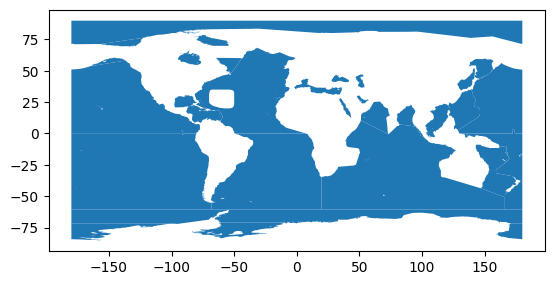

In [40]:
water_url = "https://naciscdn.org/naturalearth/110m/physical/ne_110m_geography_marine_polys.zip"
water = gpd.read_file(water_url)
water.plot()